Preview of the Titanic dataset:
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  

 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------     

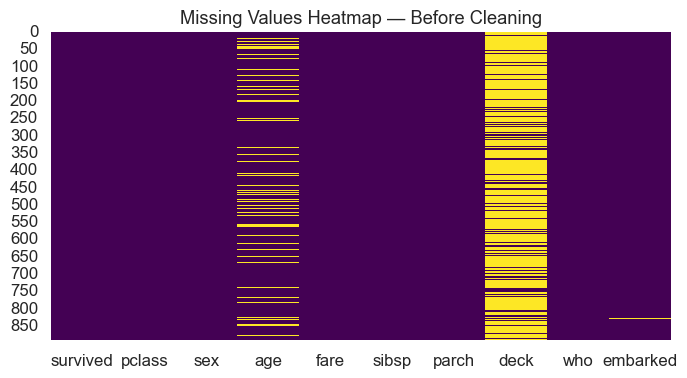


 Cleaned and engineered features are ready!


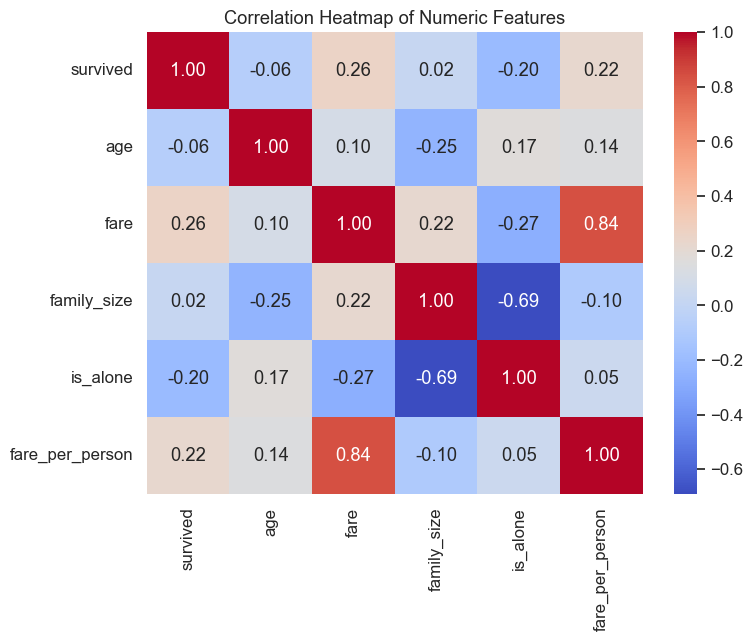

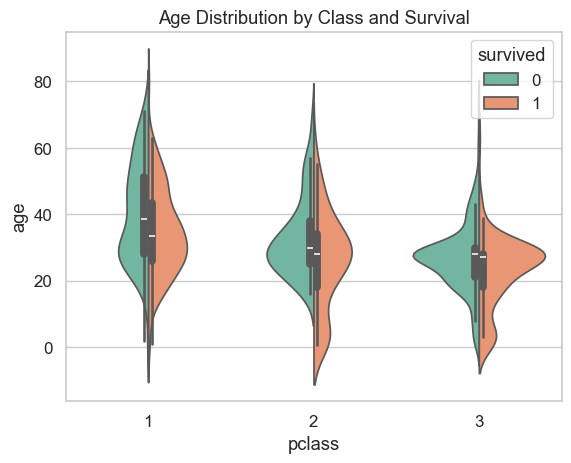

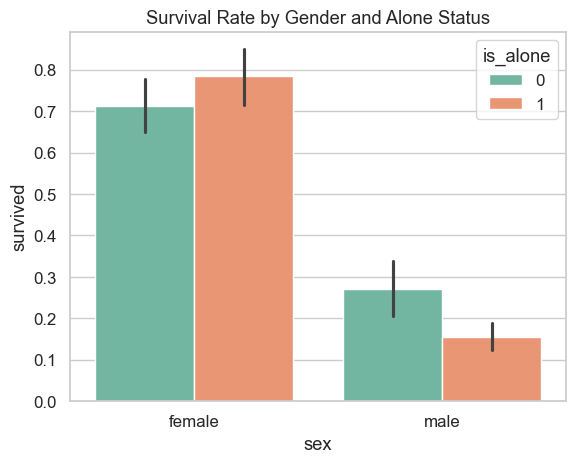

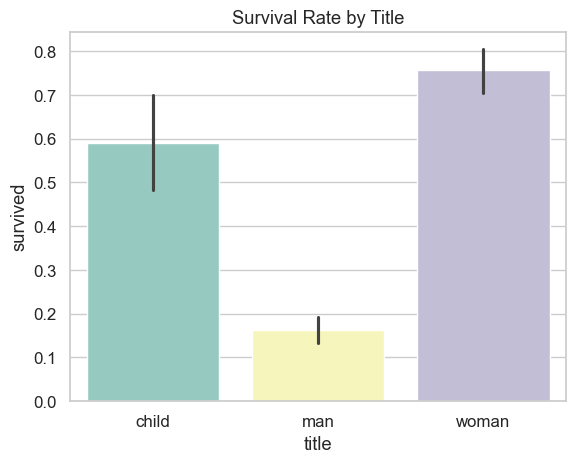

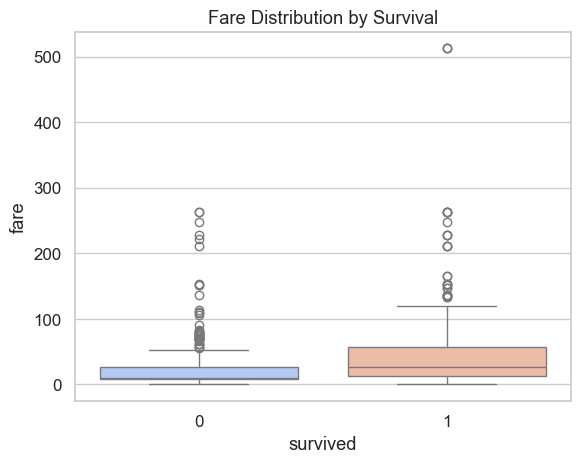


 Logistic Regression average F1 (5-fold): 0.758

 Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       165
           1       0.78      0.75      0.76       103

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



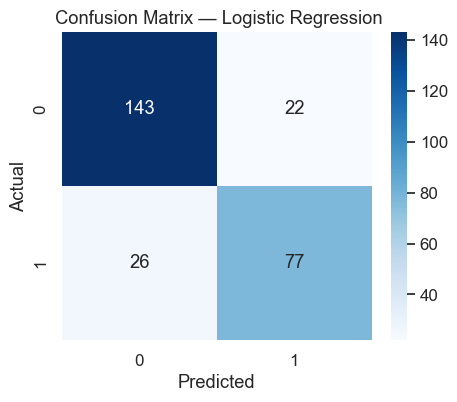


 Logistic Regression Odds Ratios:
                 Feature  Coefficient  Odds_Ratio
10           cat__deck_D     0.698219    2.010170
11           cat__deck_E     0.649533    1.914646
12           cat__deck_F     0.309202    1.362338
1              num__fare     0.221294    1.247690
18      cat__title_woman     0.204822    1.227307
15       cat__embarked_Q     0.079290    1.082518
4   num__fare_per_person    -0.041258    0.959581
6          cat__pclass_2    -0.096815    0.907724
3          num__is_alone    -0.170686    0.843086
9            cat__deck_C    -0.231253    0.793539
13           cat__deck_G    -0.237832    0.788335
8            cat__deck_B    -0.263945    0.768016
0               num__age    -0.376093    0.686539
16       cat__embarked_S    -0.398101    0.671594
2       num__family_size    -0.567751    0.566799
5          cat__sex_male    -0.720643    0.486439
7          cat__pclass_3    -1.014473    0.362593
14     cat__deck_Unknown    -1.024356    0.359028
17        cat__

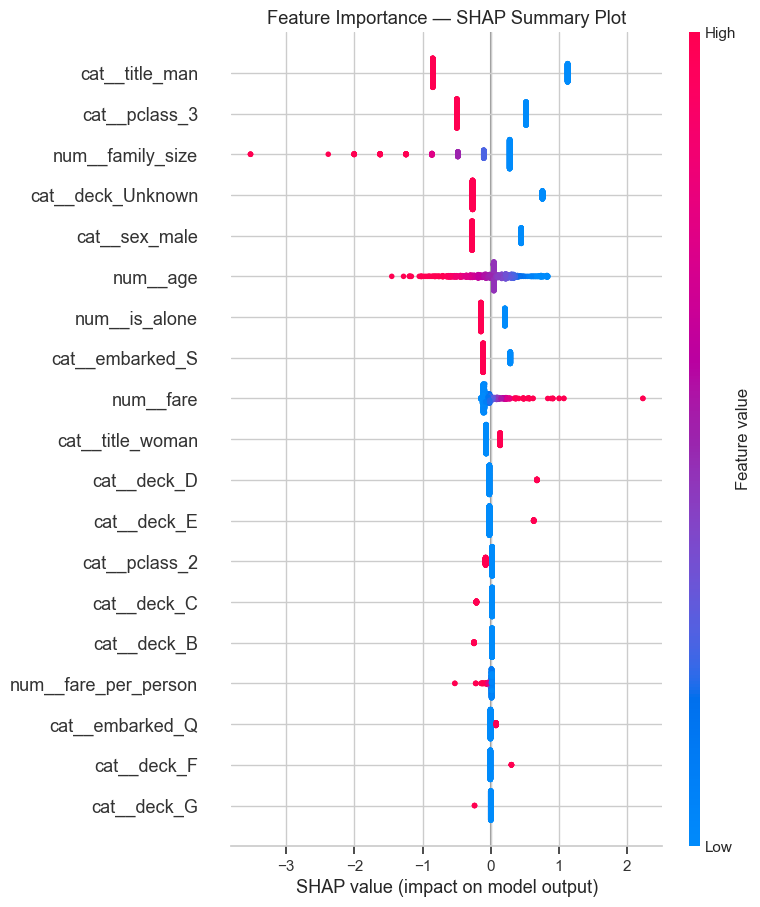


 Best Parameters from GridSearchCV:
{'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best F1 Score: 0.772

 Model pipeline saved as 'titanic_logistic_pipeline.pkl'

 Project Complete! Key Insights & Recommendations:

1️- Gender and passenger class are the strongest predictors of survival.
2️- Passengers traveling alone had lower odds of survival.
3️- Logistic Regression provides interpretable coefficients, great for baseline understanding.
4️- Feature engineering like fare per person and age brackets can improve model insights.
5️- Imputing missing values (age, embarked) helps retain more data.
6️- Visualization of survival by title or fare brackets provides additional insights.
7️- SHAP plots validate which features push survival probability up or down.
8️- Consider hyperparameter tuning (C, solver) for improved Logistic Regression performance.
9️- Adding interaction terms (e.g., sex*pclass) may improve predictive power.
10- Deploy model with a clear explanation of c

In [2]:
# Titanic Survival Prediction — Enhanced Logistic Regression Project
# ---------------------------------------------------------------
# Objective:
# Predict Titanic survival using Logistic Regression, enhanced feature engineering,
# improved EDA, and model interpretability.
#
# MODEL USED:
# Logistic Regression (binary classification)
# ---------------------------------------------------------------
# Logistic Regression is chosen for:
# - Interpretable coefficients (odds ratios)
# - Stable baseline for binary survival prediction
# - Compatibility with SHAP for feature impact explanation
# ---------------------------------------------------------------

# 1. Import Necessary Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")

# Set seaborn aesthetics
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)

# ---------------------------------------------------------------
# 2. Load and Explore Data

# Load Titanic dataset from Seaborn
df = sns.load_dataset('titanic')

print("Preview of the Titanic dataset:")
print(df.head())

print("\n Dataset Information:")
print(df.info())

# ---------------------------------------------------------------
# 3. Data Cleaning & Feature Engineering

# Keep relevant columns
df = df[['survived', 'pclass', 'sex', 'age', 'fare', 'sibsp', 'parch', 'deck', 'who', 'embarked']]

# Check missing values before cleaning
plt.figure(figsize=(8,4))
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap — Before Cleaning")
plt.show()

# Fill missing values
df['age'].fillna(df['age'].median(), inplace=True)
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)

# Keep 'deck' as categorical safely
df['deck'] = df['deck'].astype('category').cat.add_categories('Unknown').fillna('Unknown')

# Feature engineering
df['family_size'] = df['sibsp'] + df['parch'] + 1
df['is_alone'] = (df['family_size'] == 1).astype(int)
df['fare_per_person'] = df['fare'] / df['family_size']
df['title'] = df['who']
df['age_bin'] = pd.cut(df['age'], bins=[0,12,18,35,60,100],
                       labels=['Child','Teen','YoungAdult','Adult','Senior'])

# Convert categorical features
cat_cols = ['sex', 'pclass', 'deck', 'embarked', 'who', 'title', 'age_bin']
for col in cat_cols:
    df[col] = df[col].astype('category')

print("\n Cleaned and engineered features are ready!")

# ---------------------------------------------------------------
# 4. Exploratory Data Analysis (EDA)

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['survived','age','fare','family_size','is_alone','fare_per_person']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# Violin plot: Age distribution by class and survival
sns.violinplot(data=df, x='pclass', y='age', hue='survived', split=True, palette='Set2')
plt.title("Age Distribution by Class and Survival")
plt.show()

# Barplot: Survival rate by gender and alone status
sns.barplot(data=df, x='sex', y='survived', hue='is_alone', palette='Set2')
plt.title("Survival Rate by Gender and Alone Status")
plt.show()

# Barplot: Survival by title
sns.barplot(data=df, x='title', y='survived', palette='Set3')
plt.title("Survival Rate by Title")
plt.show()

# Boxplot: Fare by survival
sns.boxplot(data=df, x='survived', y='fare', palette='coolwarm')
plt.title("Fare Distribution by Survival")
plt.show()

# ---------------------------------------------------------------
# 5. Machine Learning Pipeline — Logistic Regression Only

# Features and target
X = df[['sex','pclass','age','fare','family_size','is_alone','deck','embarked','title','fare_per_person']]
y = df['survived']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

# Preprocessing
num_features = ['age','fare','family_size','is_alone','fare_per_person']
cat_features = ['sex','pclass','deck','embarked','title']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
])

# Logistic Regression pipeline
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', log_model)
])

# Cross-validation
cv_score = cross_val_score(log_pipeline, X, y, cv=5, scoring='f1').mean()
print(f"\n Logistic Regression average F1 (5-fold): {cv_score:.3f}")

# Fit and predict
log_pipeline.fit(X_train, y_train)
y_pred = log_pipeline.predict(X_test)

print("\n Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title(" Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------------------------------------------------------
# 6. Model Interpretability — Odds Ratios & SHAP

# Odds ratios for logistic regression
coefs = log_pipeline.named_steps['model'].coef_[0]
features = preprocessor.get_feature_names_out()
odds_ratios = pd.DataFrame({'Feature': features, 'Coefficient': coefs})
odds_ratios['Odds_Ratio'] = np.exp(odds_ratios['Coefficient'])
print("\n Logistic Regression Odds Ratios:")
print(odds_ratios.sort_values('Odds_Ratio', ascending=False))

# SHAP explanation
X_preprocessed = pd.DataFrame(preprocessor.transform(X_train),
                              columns=preprocessor.get_feature_names_out())
explainer = shap.Explainer(log_pipeline.named_steps['model'], X_preprocessed)
shap_values = explainer(X_preprocessed)

# Clearer SHAP summary plot
shap.summary_plot(shap_values, X_preprocessed, show=False)
plt.title("Feature Importance — SHAP Summary Plot")
plt.show()

# ---------------------------------------------------------------
# 7. Hyperparameter Tuning (Optional Enhancement)

param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs', 'liblinear']
}

grid = GridSearchCV(log_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

print("\n Best Parameters from GridSearchCV:")
print(grid.best_params_)
print(f"Best F1 Score: {grid.best_score_:.3f}")

# ---------------------------------------------------------------
# 8. Save Model & Preprocessor

joblib.dump(log_pipeline, 'titanic_logistic_pipeline.pkl')
print("\n Model pipeline saved as 'titanic_logistic_pipeline.pkl'")

# ---------------------------------------------------------------
# 9. Final Takeaways & Recommendations

print("\n Project Complete! Key Insights & Recommendations:")
print("""
1️- Gender and passenger class are the strongest predictors of survival.
2️- Passengers traveling alone had lower odds of survival.
3️- Logistic Regression provides interpretable coefficients, great for baseline understanding.
4️- Feature engineering like fare per person and age brackets can improve model insights.
5️- Imputing missing values (age, embarked) helps retain more data.
6️- Visualization of survival by title or fare brackets provides additional insights.
7️- SHAP plots validate which features push survival probability up or down.
8️- Consider hyperparameter tuning (C, solver) for improved Logistic Regression performance.
9️- Adding interaction terms (e.g., sex*pclass) may improve predictive power.
10- Deploy model with a clear explanation of coefficients for business insights.
11- Regularly validate model on updated or external datasets for robustness.
""")
